In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
## Importing dataset
secom = pd.read_spss('Data/secom_mod.sav')

### Splitting the data 20% goes for testing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

y = secom['class']
X = secom.drop(['class', 'ID', 'timestamp'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.copy()
X_test = X_test.copy()

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 6.23
% Positive class in Test  = 5.41


In [4]:
pd.set_option('display.max_columns', None)

### Changing types of target feature to be Categorical

In [5]:
y_train = y_train.astype('category')
y_test = y_test.astype('category') 
assert y_train.dtype == 'category'

### Feature Selection

### Now We look for null values overpassing the 45% on the features

In [6]:
numericalFeatures = X_train.iloc[:,2:-1]

#### A graphical representation of current null values

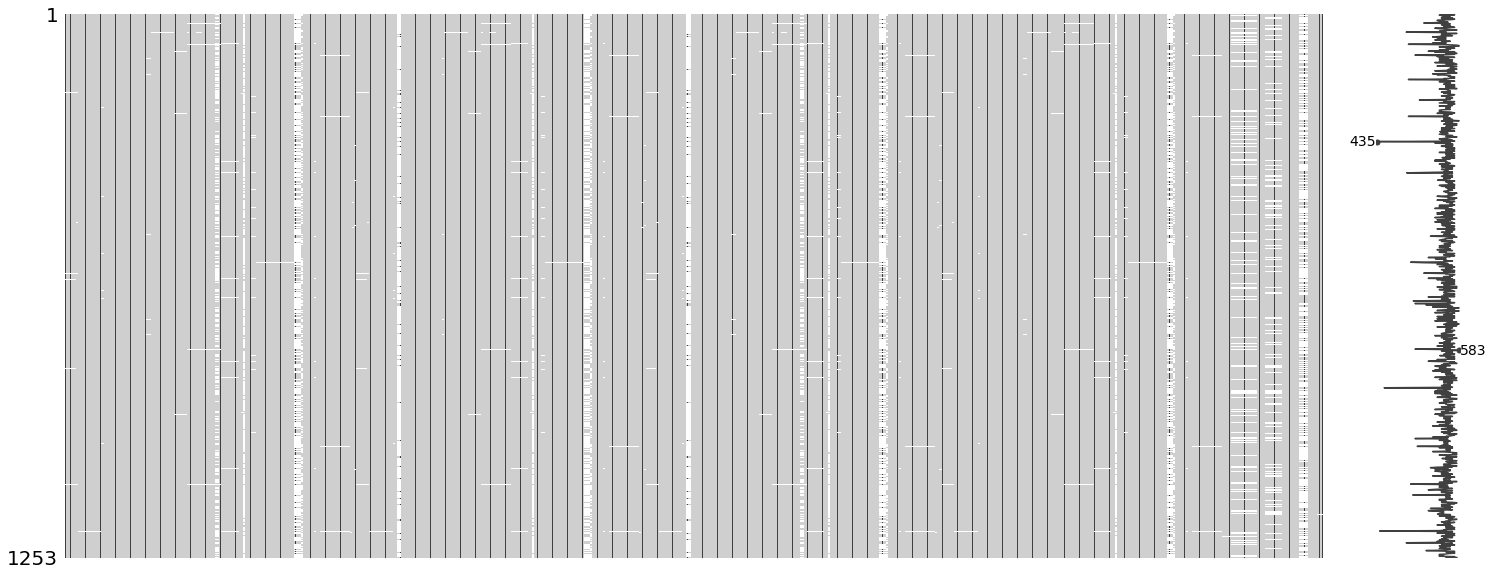

In [7]:
import missingno as msno

msno.matrix(numericalFeatures.head(1000000))
plt.show()

#### Checking if there is a column with more than 55% values missing or NaN

In [8]:
num_of_features_to_delete = 0
colsToDrop = []
for col in numericalFeatures.columns:
    if (numericalFeatures[col].isna().sum() > 700):
        num_of_features_to_delete +=1
        
        colsToDrop.append(col)
        
X_train.drop(colsToDrop, axis=1, inplace=True)
X_test.drop(colsToDrop, axis=1, inplace=True)

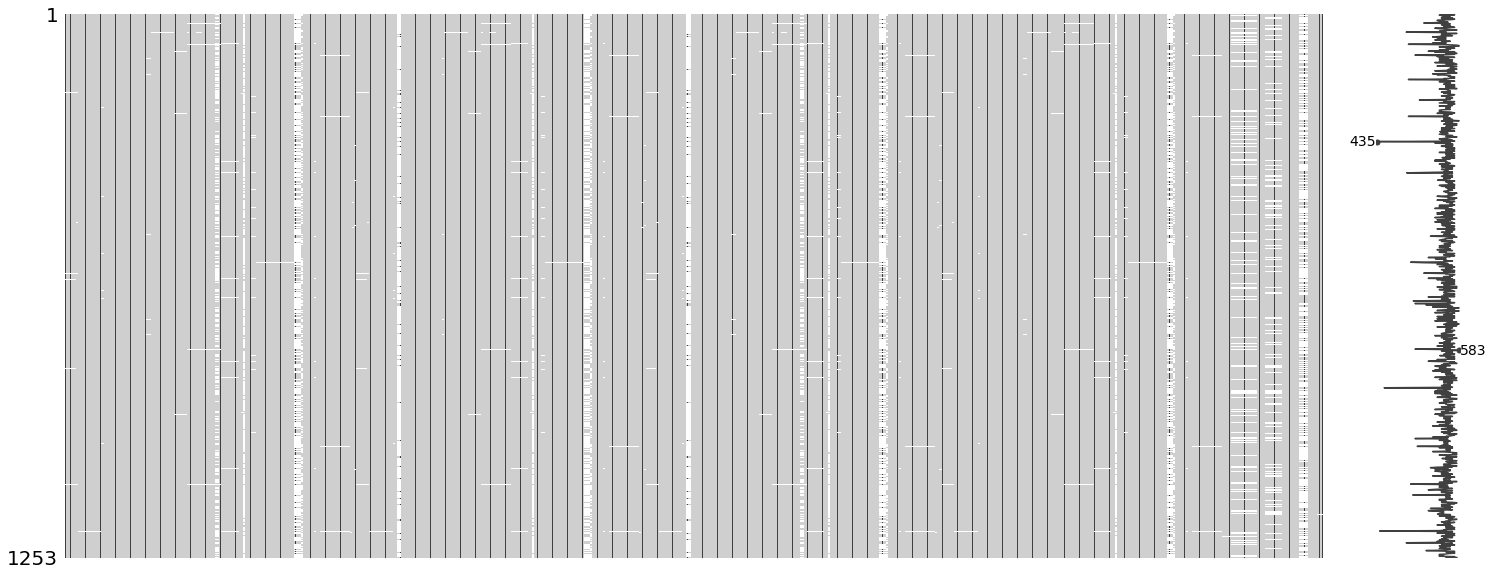

In [9]:
msno.matrix(numericalFeatures)
plt.show()

After deleting columns with nulls more than 45% of missing values, the data now has only 436 features

### Selecting Features based on Variance

Here we are selecting the features with low variance, sklearn provides the function
VarianceThreshold that receives a threshold, which will drop the percentage indicated of 
features with low variance. this method requires the dataset to be normalized

In [10]:
# First we normalized the data 
normalized_df = X_train / X_train.mean()
# Then we call sklearn function Variance Threshold to 
sel = VarianceThreshold(threshold=0.005)
sel.fit(normalized_df)

C:\Users\s0576699\Anaconda3\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.005)

get_support is the array result of executing VarianceThreshold, True means column to keep otherwise to be dropped

In [11]:
# this is a mask that will allow to drop the columns
mask = sel.get_support()

In [12]:
X_train = X_train.loc[:, mask]
X_test =  X_test.loc[:, mask]

### Feature removal based on relation among variables

In [13]:
X_train.corr() == 0

,feature004,feature005,feature008,feature010,feature011,feature015,feature017,feature022,feature023,feature024,feature025,feature026,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature075,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature093,feature094,feature095,feature096,feature097,feature099,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature115,feature118,feature123,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature181,feature182,feature183,feature184,feature185,feature186,feature188,feature189,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature222,feature223,feature224,feature225,feature226,feature228,feature229,feature239,feature240,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature317,feature318,feature319,feature320,feature321,feature322,feature324,feature325,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature360,feature361,feature362,feature363,feature364,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature387,feature388,feature389,feature390,feature391,feature392,feature393,feature394,feature406,feature407,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature422,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature431,feature432,feature433,feature434,feature435,feature436,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature444,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature544,feature545,feature546,feature547,feature550,feature551,feature552,feature553,feature554,feature555,feature556,feature557,feature558,featur

In [14]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = X_train.corr().abs()

# Create a True/False mask and apply it
maskcorr = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(maskcorr)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop the features in the to_drop list
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

print("The reduced dataframe has {} columns.".format(X_train.shape[1]))

The reduced dataframe has 213 columns.


### Removing outliers using z-score (We can later impute them)

In [15]:
## Getting the mean, standard deviation and z_scores to detect outliers

data_mean, data_std  = X_train.mean(), X_train.std()
data_z_scores = ((X_train - data_mean) / data_std).abs()
data_z_scores

,feature004,feature008,feature010,feature011,feature015,feature022,feature023,feature024,feature025,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature096,feature097,feature099,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature201,feature202,feature211,feature271,feature274,feature275,feature276,feature279,feature281,feature282,feature286,feature295,feature296,feature297,feature298,feature301,feature303,feature304,feature309,feature317,feature325,feature336,feature337,feature338,feature339,feature341,feature345,feature347,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature363,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature388,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature432,feature433,feature434,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature545,feature546,feature547,feature553,feature556,feature557,feature558,feature559,feature561,feature562,feature564,feature568,feature569,feature570,feature572,feature576,feature577,feature578,feature586,feature587,feature589,feature590
708,0.957600,0.268093,1.169365,0.575636,1.068840,0.976065,0.588321,0.307683,0.565155,0.381021,1.227126,1.058262,1.100097,1.819505,0.065047,NaN,NaN,0.946798,1.133239,0.123371,0.618504,0.611535,0.461812,0.218641,0.057730,0.465379,NaN,1.464431,1.024079,0.057971,0.356288,0.236223,1.304505,0.390907,0.095618,0.162974,2.105933,0.383400,2.627351,3.274255,1.050107,3.063824,0.868906,1.404457,0.372705,0.917590,0.219498,1.614426,1.133477,0.026519,0.714317,0.638332,0.553941,0.182432,2.025893,0.311766,1.626922,0.449197,0.528798,1.004439,1.054995,0.614653,0.705576,0.057226,1.698103,1.216985,0.318667,0.254772,0.672623,0.687679,0.676475,0.711265,0.273989,0.684636,0.482412,0.158927,0.709596,0.631292,0.220415,0.078765,0.534249,0.041623,0.062567,0.199509,NaN,1.001993,0.184113,0.731885,0.377488,0.175513,0.396626,0.441960,0.115560,0.643523,0.329388,0.651106,0.614509,1.373887,0.439427,0.561598,0.911702,0.379366,0.073118,0.233765,0.538382,0.659616,1.886429,0.254088,0.407746,0.257749,0.114098,1.607697,0.406157,0.541323,1.562009,0.205738,0.691429,0.265715,0.071254,0.377251,0.444820,0.215990,0.327958,0.496748,0.567068,0.874801,0.143220,0.850565,0.517179,0.196709,1.303509,0.921157,0.730842,0.155078,0.399120,0.249982,0.873268,0.630947,0.578071,1.645448,1.064605,0.463888,0.531544,0.227646,0.172662,0.111963,0.208495,0.226857,0.039194,0.594522,0.378143,1.379290,0.525607,0.147889,0.237540,0.373718,0.421102,0.028318,0.389382,0.117093,0.716658,0.626109,0.614817,0.332911,2.078785,0.513197,1.147343,1.198968,0.600822,0.545490,1.389818,0.077961,0.271441,0.666054,0.760741,0.814697,0.741327,0.507149,0.830268,0.469115,0.188317,0.114878,0.764462,0.093310,0.034170,0.19094

In [16]:
maskz = data_z_scores < 3

In [17]:
# Replaces with na all the outlier values so that we can impute them later
# this is only done on the train dataset , because on the real world we will 
# receive outliers and the model has to learn to deal with it 
X_train = X_train.mask(~maskz)

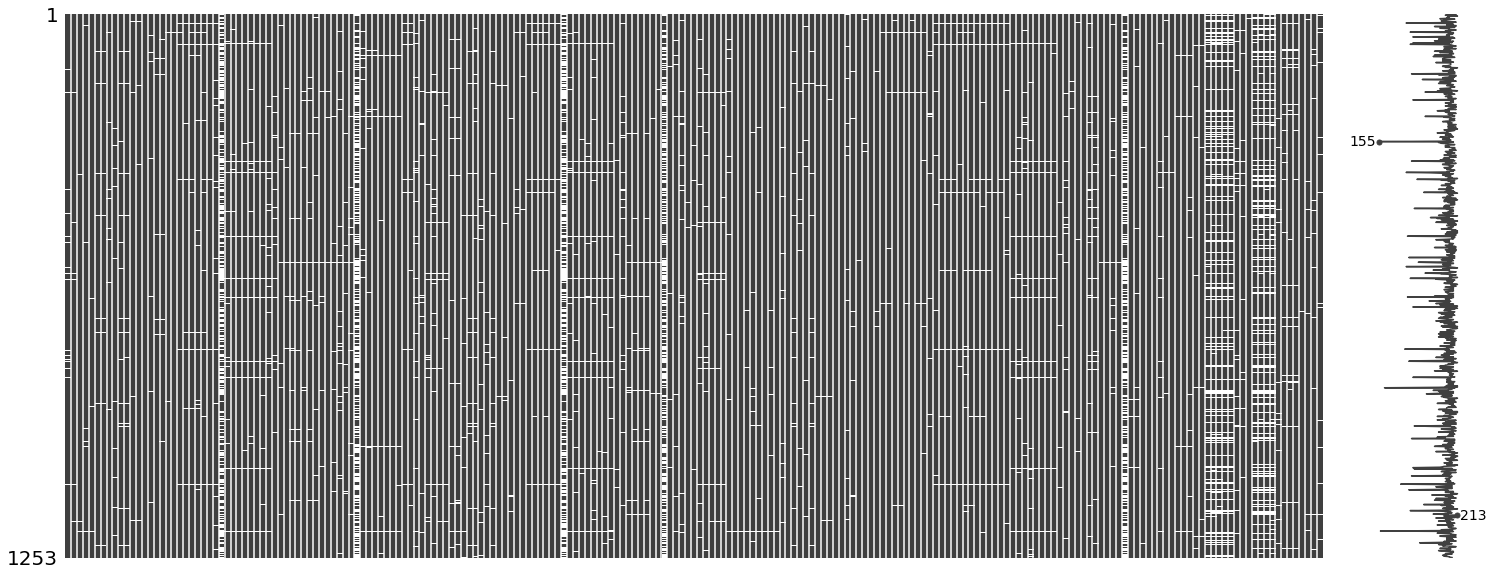

In [18]:
msno.matrix(X_train.mask(~maskz))
plt.show()

In [19]:
X_train.drop_duplicates()

,feature004,feature008,feature010,feature011,feature015,feature022,feature023,feature024,feature025,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature096,feature097,feature099,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature201,feature202,feature211,feature271,feature274,feature275,feature276,feature279,feature281,feature282,feature286,feature295,feature296,feature297,feature298,feature301,feature303,feature304,feature309,feature317,feature325,feature336,feature337,feature338,feature339,feature341,feature345,feature347,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature363,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature388,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature432,feature433,feature434,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature545,feature546,feature547,feature553,feature556,feature557,feature558,feature559,feature561,feature562,feature564,feature568,feature569,feature570,feature572,feature576,feature577,feature578,feature586,feature587,feature589,feature590
708,966.5755,0.1242,-0.0185,0.0057,11.9662,-6233.50,2875.75,-4262.00,1367.5000,1.8585,5.0568,1.9222,0.1472,4.6448,9.0425,NaN,NaN,1.3565,226.7110,1.7755,111.0918,18.5782,18.2245,25.5500,0.8175,89.2668,NaN,-0.0398,-0.0641,-0.0078,-0.0314,0.0083,-0.0824,-0.0145,0.0032,0.1984,-0.1828,0.0001,-0.5845,NaN,-0.0004,NaN,0.0575,-0.0142,0.0003,0.0024,0.0012,-0.1426,-0.1105,0.4555,0.9791,2.912,0.5709,3.138,1.9390,0.7713,34.6672,13.43,4.96,0.0456,20.1801,22.5488,74.8940,0.0389,0.0017,0.0100,0.0134,1.8702,74.5229,57.9849,544.3853,43.8368,0.0584,0.2587,0.0331,0.2240,6.7019,17.5690,2.1387,9.2006,1.3492,2.8357,0.0380,21.4334,NaN,0.0124,0.0232,0.0126,0.0184,0.0211,0.0466,0.0478,0.0316,1.5381,0.0264,0.0070,0.0064,0.0077,0.0022,0.0019,0.0020,0.0059,0.0,1.1477,3.9304,3.3771,0.8954,2.7633,23.2963,12.7253,6.1491,5.0735,6.5597,158.2714,819.3407,1.1366,54.7794,1.6482,5.0757,0.8335,2.5928,1.9186,6.1320,4.1728,27.5223,7.8245,2.7686,5.4665,36.4162,63.1698,3.4232,0.6335,0.8717,0.9201,0.7027,1.2220,0.3575,0.1809,5.8777,1.6597,4.5779,4.0836,7.6700,4.1468,2.5883,30.6099,4.4526,279.3651,5.5540,2.2664,5.7430,72.2891,27.2160,41.5615,3.6202,14.6243,11.1753,0.0,2.1795,71.4151,114.5549,85.9259,350.1597,129.7297,902.3467,100.9107,637.5215,0.0000,61.8334,1.7765,1.1710,0.4897,7.7940,47.1566,8.0600,0.0000,0.0000,36.0106,0.0000,4.2122,1.5822,0.0,9.1233,0.0861,5.0486,4.7732,2.2632,7.2062,2.0308,1.9086,10.5371,0.0026,7.1160,0.6122,0.0775,29.8386,3.5878,1.2414,0.9618,0.0527,24.2589,0.5671,0.0382,1.8844,15.4662,2.0161,0.1038,1.5148,15.9361,2.1830,0.0161,0.0105,217.1506
1318,1665.0062,0.1227,-0.0037,0.0039,9.4855,-5731.25,2725.50,-3950.00,-2667.7500,1.9675,7.2722,2.6667,0.2127

### Imputation of Data Using KNN

In [20]:
# prior to any imputation we concatenate the X and y because model won't accept any nulls on features

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)


train_data = pd.concat([X_train, y_train], axis=1)
train_imputed = pd.DataFrame(imputer.fit_transform(train_data),columns = train_data.columns)

#we impute target feature as well on test data because model won't admit null values
test_data = pd.concat([X_test, y_test], axis=1)
test_imputed = pd.DataFrame(imputer.fit_transform(train_data),columns = test_data.columns)


In [21]:
# assigning all variables back 
y_train = train_imputed['class']
y_test = test_imputed['class']

train_imputed.drop('class', axis='columns', inplace=True)
test_imputed.drop('class', axis='columns', inplace=True)

X_train = train_imputed
X_test = test_imputed

### Boruta for Feature Selection 

Here we are using boruta for feature selection:

- **Green:** Stands for features boruta is quite sure are useful for the model, so we should keep them

- **Blue:** Stands for features boruta is not quite sure whether will have a significant impact on the model or not (HERE WE COULD DECIDE TO KEEP IT OR NOT), for this Script we will keep them!

- **Red**: Features to be dropped

In [22]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 8,
    class_weight='balanced'
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 50 # number of trials to perform
    , perc = 60,
    random_state=4242
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(X_train.values, y_train.values.ravel())
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features to keep', green_area)
print('features to that the model is not quite sure whether work or no', blue_area)

features to keep ['feature011', 'feature015', 'feature022', 'feature024', 'feature032', 'feature034', 'feature041', 'feature060', 'feature063', 'feature064', 'feature065', 'feature066', 'feature068', 'feature077', 'feature079', 'feature080', 'feature082', 'feature092', 'feature103', 'feature104', 'feature113', 'feature126', 'feature127', 'feature128', 'feature130', 'feature131', 'feature201', 'feature211', 'feature296', 'feature317', 'feature325', 'feature336', 'feature339', 'feature345', 'feature347', 'feature349', 'feature352', 'feature366', 'feature378', 'feature386', 'feature418', 'feature421', 'feature424', 'feature425', 'feature426', 'feature427', 'feature429', 'feature430', 'feature446', 'feature447', 'feature448', 'feature453', 'feature455', 'feature456', 'feature461', 'feature469', 'feature470', 'feature474', 'feature476', 'feature478', 'feature489', 'feature490', 'feature511', 'feature520', 'feature525', 'feature542', 'feature553', 'feature562', 'feature564', 'feature572', 'f

**Green**: Stands for features boruta is quite sure are useful for the model, so we should keep them

**Blue**: Stands for features boruta is not quite sure whether will have a significant impact on 
the model or not (HERE WE COULD DECIDE TO KEEP IT OR NOT), for this Variance we will keep them!

In [23]:
print('Green',len(green_area))
print('Blue', len(blue_area))

Green 72
Blue 26


In [24]:
X_train = pd.concat([X_train[green_area], X_train[blue_area]], axis=1)
X_test = pd.concat([X_test[green_area], X_test[blue_area]], axis=1)

# Pedro`s code

In [25]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1253, 98)
Shape of X after SMOTE: (2350, 98)

Balance of positive and negative classes (%):


0.0    50.0
1.0    50.0
Name: class, dtype: float64

Accuracy = 1.00
Recall = 1.00



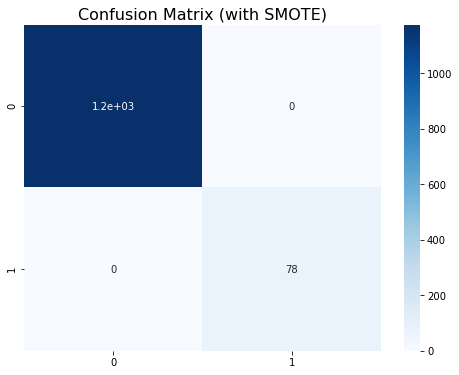

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

#X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42 )

model = RandomForestClassifier(random_state=42)
model.fit(X_sm, y_sm)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');